<a href="https://colab.research.google.com/github/saiteja-ms/DAL-Project/blob/main/Assignment_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing required libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
from sklearn.model_selection import GridSearchCV

In [ ]:
class Adaboost(BaseEstimator, ClassifierMixin):
    """
    Adaboost classifier implementation:
             This class implements the Adaboost algorithm, which combines multiple weak
    classifiers to create a strong classifier.
    """

    def __init__(self, base_estimator=None, n_estimators=50, eta=0.5):
        """
        Initialize the Adaboost classifier

        - param base_estimator: The weak classifier to use (default: DecisionTreeClassifier with max_depth=1)
        - param n_estimators: The number of weak classifiers to train
        - param eta: Learning rate
        """
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.eta = eta
        self.estimators_ = []
        self.estimator_weights_ = []

    def fit(self, X, y):
        """
        Fit the Adaboost classifier to the training data.

        - param X: Training features
        - param y: Training labels
        - return: self
        """
        if self.base_estimator is None:
            self.base_estimator = DecisionTreeClassifier(max_depth=1)

        n_samples = X.shape[0]
        sample_weight = np.ones(n_samples) / n_samples

        for _ in range(self.n_estimators):
            # Train a new weak classifier
            estimator = self.base_estimator.__class__(**self.base_estimator.get_params())

            # Check if the estimator supports sample_weight
            if 'sample_weight' in estimator.fit.__code__.co_varnames:
                estimator.fit(X, y, sample_weight=sample_weight)
            else:
                # If not, fit without sample_weight
                estimator.fit(X, y)

            # Make predictions and calculate the error
            y_pred = estimator.predict(X)
            incorrect = (y_pred!=y)
            estimator_error = np.mean(np.average(incorrect, weights=sample_weight, axis=0))

            # Calculate the weight of the estimator
            estimator_weight = self.eta * np.log((1 - estimator_error) / estimator_error)

            # Update sample weights
            sample_weight *= np.exp(estimator_weight * incorrect)
            sample_weight /= np.sum(sample_weight)

            # Store the trained classifier and its weight
            self.estimators_.append(estimator)
            self.estimator_weights_.append(estimator_weight)

        return self

    def predict(self, X):
        """
        Make predictions using the trained Adaboost classifier.

        - param X: Features to predict
        - return: Predicted labels
        """
        predictions = np.array([estimator.predict(X) for estimator in self.estimators_])
        return np.sign(np.dot(self.estimator_weights_, predictions))

    def visualize_iterations(self, X, y, n_iterations=5):
        """
        Visualize the decision boundary at different stages of training.

        - param X: Training features
        - param y: Training labels
        - param n_iterations: Number of stages to visualize
        """
        fig, axes = plt.subplots(1, n_iterations, figsize=(20,4))
        x_min, x_max = X[:, 0].min() - 1, X[:,0].max()+1
        y_min, y_max = X[:, 1].min() - 1, X[:,1].max()+1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

        for i,ax in enumerate(axes):
            if i == 0:
                # Plot original data
                ax.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black')
                ax.set_title('Original Data')
            else:
                # Plot decision boundary at different stages
                n_estimators = i * (self.n_estimators // n_iterations)
                Z = np.sum([self.estimator_weights_[j] * self.estimators_[j].predict(np.c_[xx.ravel(), yy.ravel()]) for j in range(n_estimators)], axis=0)
                Z = np.sign(Z)
                Z = Z.reshape(xx.shape)

                ax.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
                ax.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black')
                ax.set_title(f'After {n_estimators} iterations')

            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
            ax.set_xticks(())
            ax.set_yticks(())

        plt.tight_layout()
        plt.show()

    def visualize_final_boundary(self, X, y):
        """
        Visualize the final decision boundary of the Adaboost classifier.

        - param X: Training features
        - param y: Training labels
        """
        x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
        y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                             np.arange(y_min, y_max, 0.02))

        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        plt.figure(figsize=(10,8))
        plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
        plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.title("Adaboost Decision Boundary")
        plt.show()

def generate_circle_data():
    """
    Generate the circle dataset for classification

    - return: X_train, X_test, y_train, y_test
    """
    X, y = make_circles(n_samples=500, noise=0.1, random_state=42, factor=0.2)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    return X_train, X_test, y_train, y_test

def tune_hyperparameters(X, y, classifier, param_grid):
    """
    Perform hyperparameter tuning using GridSearchCV

    - param X: Training features
    - param y: Training labels
    - param classifier: The classifier to tune
    - param param_grid: Dictionary of hyperparameters to search
    - return: Best estimator, best parameters, best score
    """
    grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X, y)
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

def run_adaboost_with_weak_classifier(X_train, X_test, y_train, y_test, weak_classifier, n_estimators=50, eta=0.5):
    """
    Run Adaboost witha specific weak classifier and visualize results.

    - param X_train: Training features
    - param X_test: Test features
    - param y_train: Training labels
    - param y_test: Test labels
    - param weak_classifier: The weak classifier to use
    - param n_estimators: Number of estimators for Adaboost
    - param eta: Learning rate for Adaboost
    - return: Trained Adaboost model, train score, test score
    """
    adaboost = Adaboost(base_estimator=weak_classifier, n_estimators=n_estimators, eta=eta)
    adaboost.fit(X_train, y_train)

    train_score = adaboost.score(X_train, y_train)
    test_score = adaboost.score(X_test, y_test)

    print(f"Train accuracy: {train_score:.4f}")
    print(f"Test accuracy: {test_score:.4f}")

    adaboost.visualize_iterations(X_train, y_train)
    adaboost.visualize_final_boundary(X_train, y_train)

    return adaboost, train_score, test_score



Running Adaboost with Logistic Regression:
Train accuracy: 0.3227
Test accuracy: 0.2640


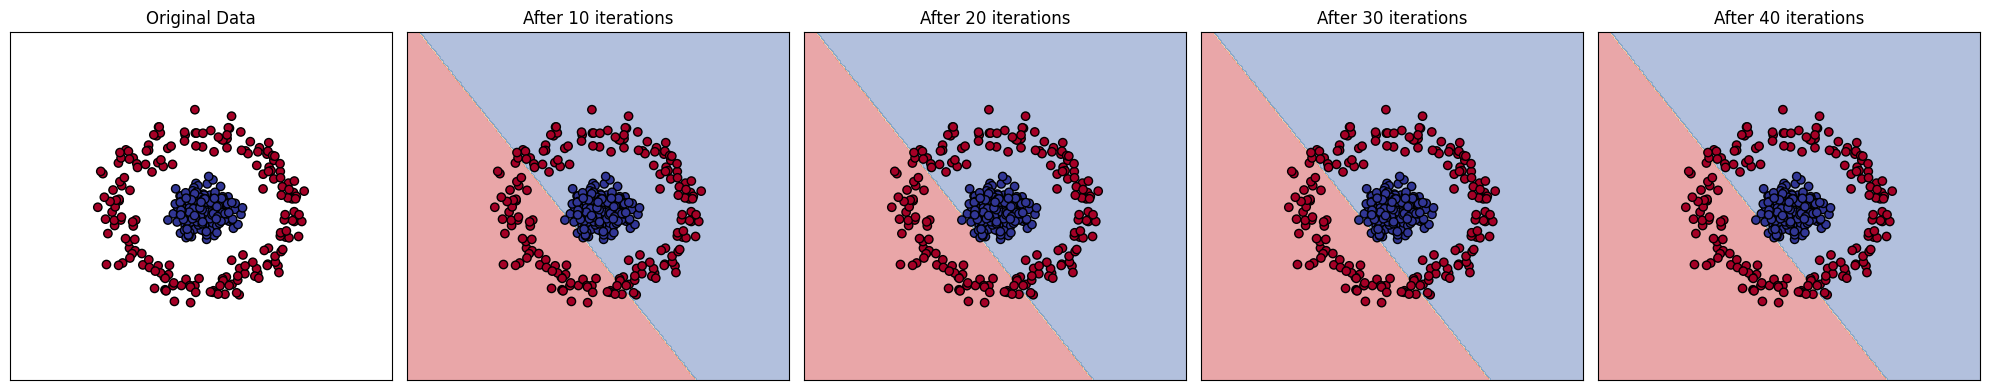

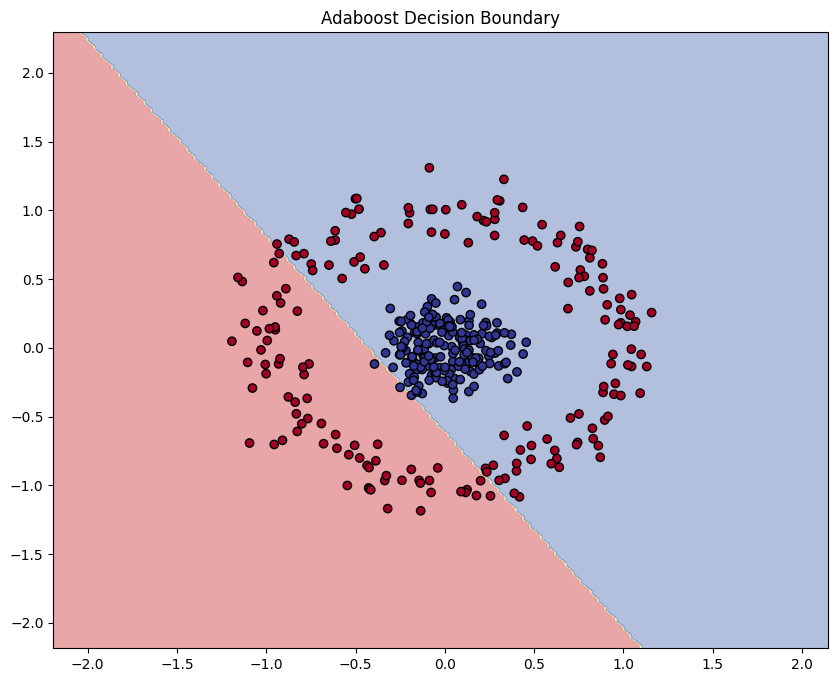

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_response.py", line 199, in _get_response_values
    classes = estimator.classe

Best parameters: {'eta': 0.1, 'n_estimators': 10}
Best cross-validation score: nan
Best model - Train accuracy: 0.3227
Best model - Test accuracy: 0.2640


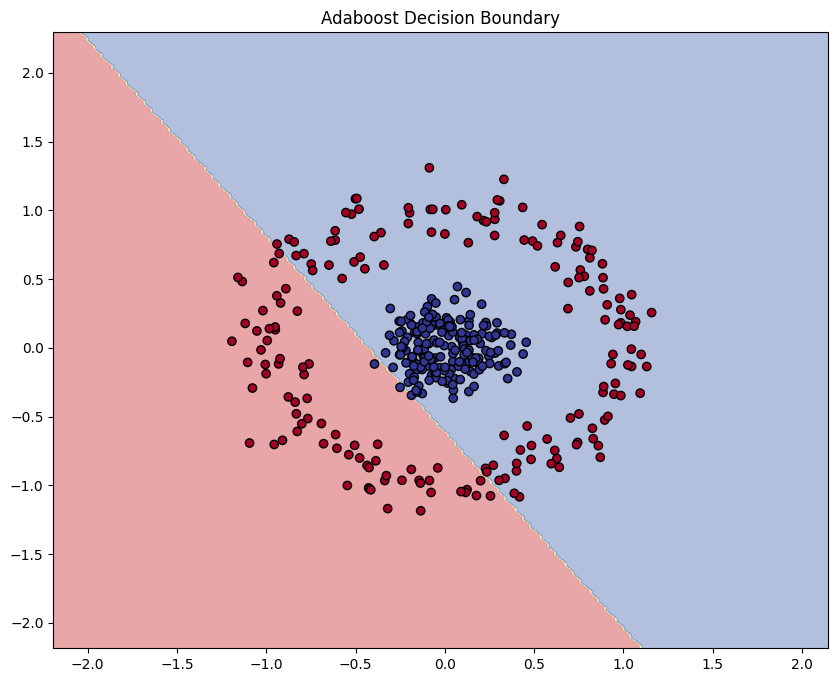


Running Adaboost with Decision Stump:
Train accuracy: 0.6933
Test accuracy: 0.7120


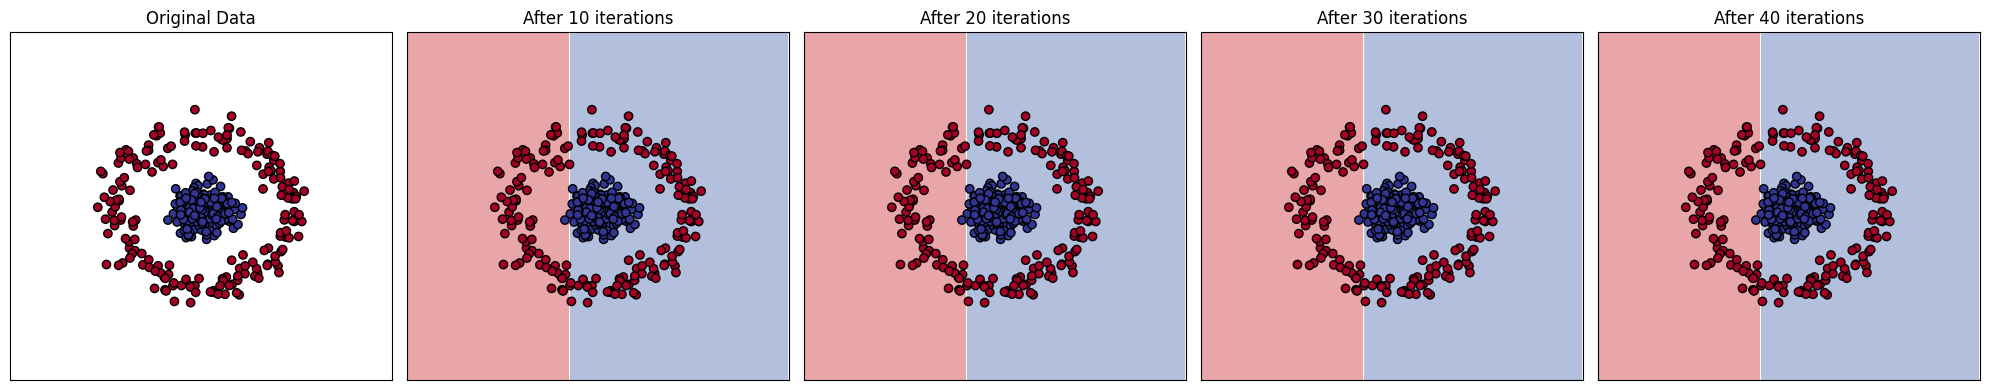

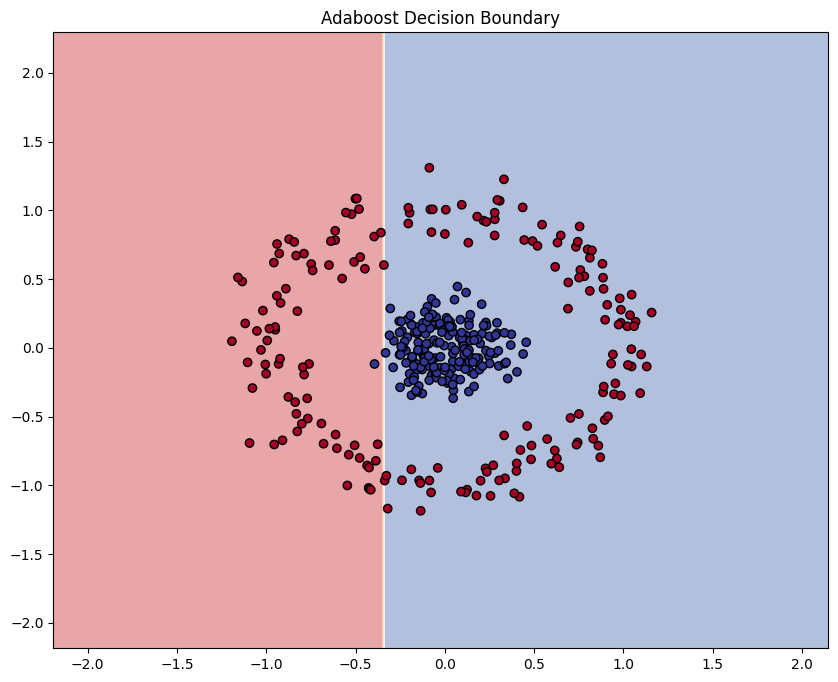

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_response.py", line 199, in _get_response_values
    classes = estimator.classe

Best parameters: {'eta': 0.1, 'n_estimators': 10}
Best cross-validation score: nan
Best model - Train accuracy: 0.6933
Best model - Test accuracy: 0.7120


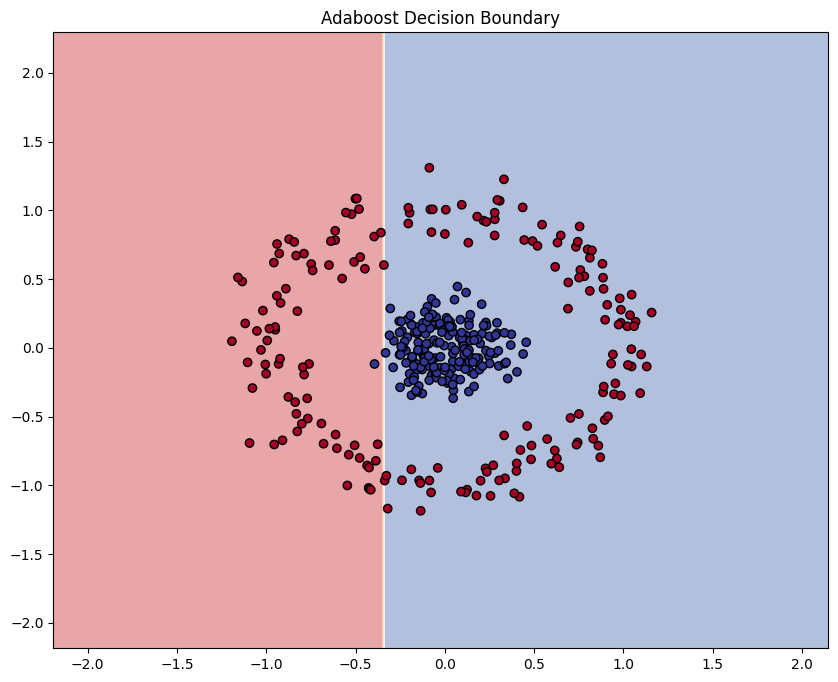


Running Adaboost with Decision Tree(depth=3):
Train accuracy: 0.9387
Test accuracy: 0.9120


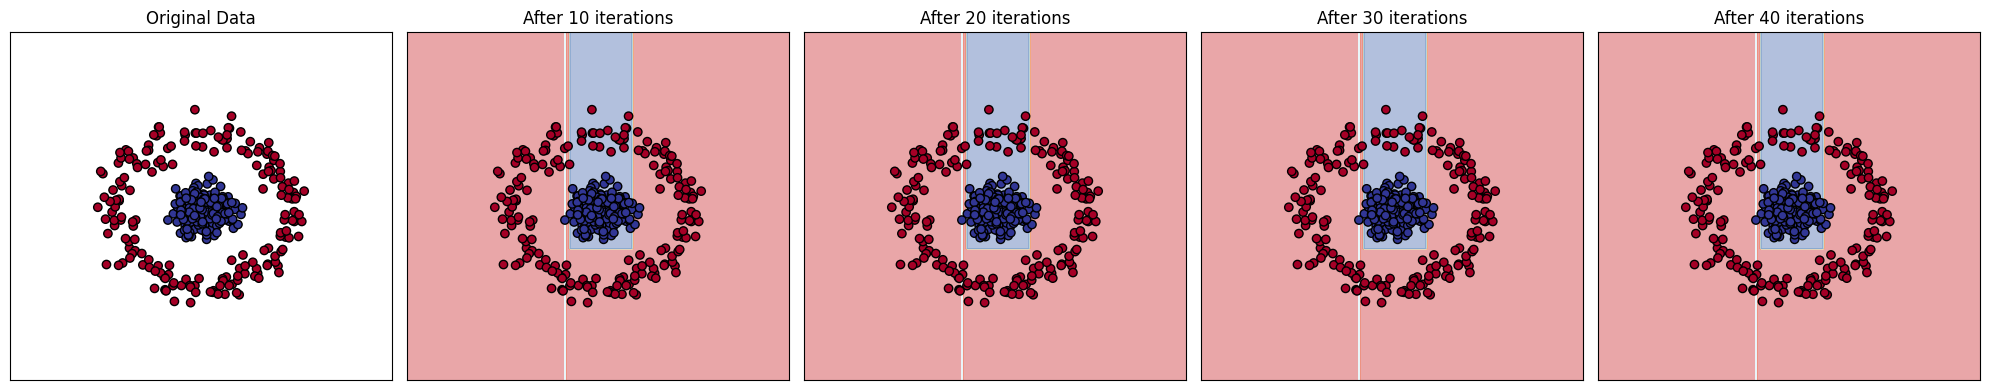

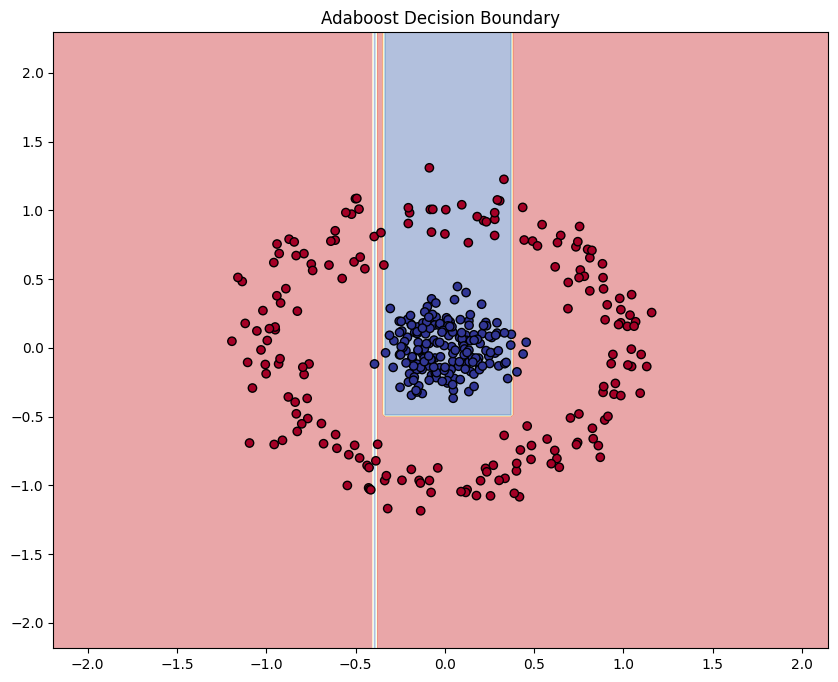

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_response.py", line 199, in _get_response_values
    classes = estimator.classe

Best parameters: {'eta': 0.1, 'n_estimators': 10}
Best cross-validation score: nan
Best model - Train accuracy: 0.9387
Best model - Test accuracy: 0.9120


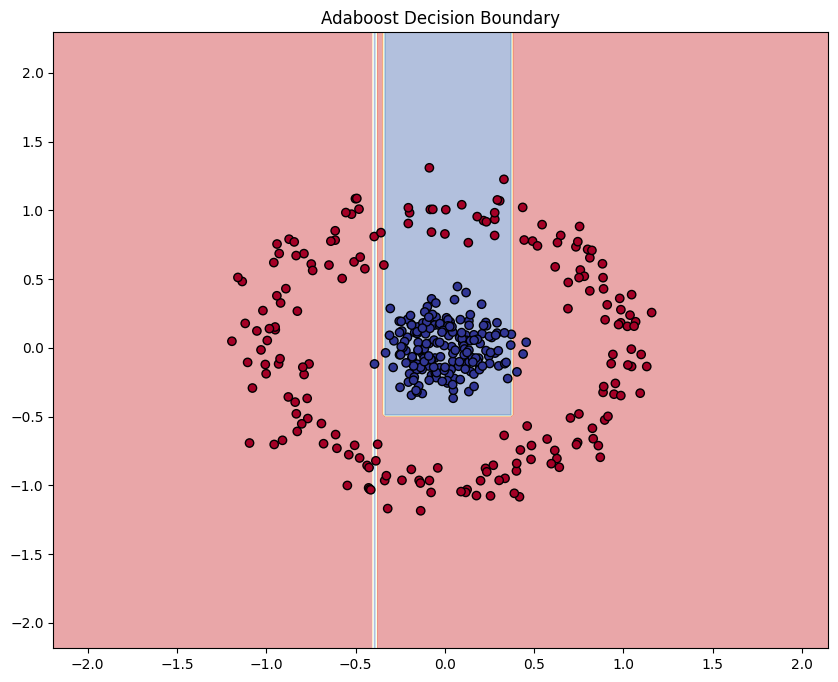


Running Adaboost with Linear SVM:
Train accuracy: 0.3227
Test accuracy: 0.2640


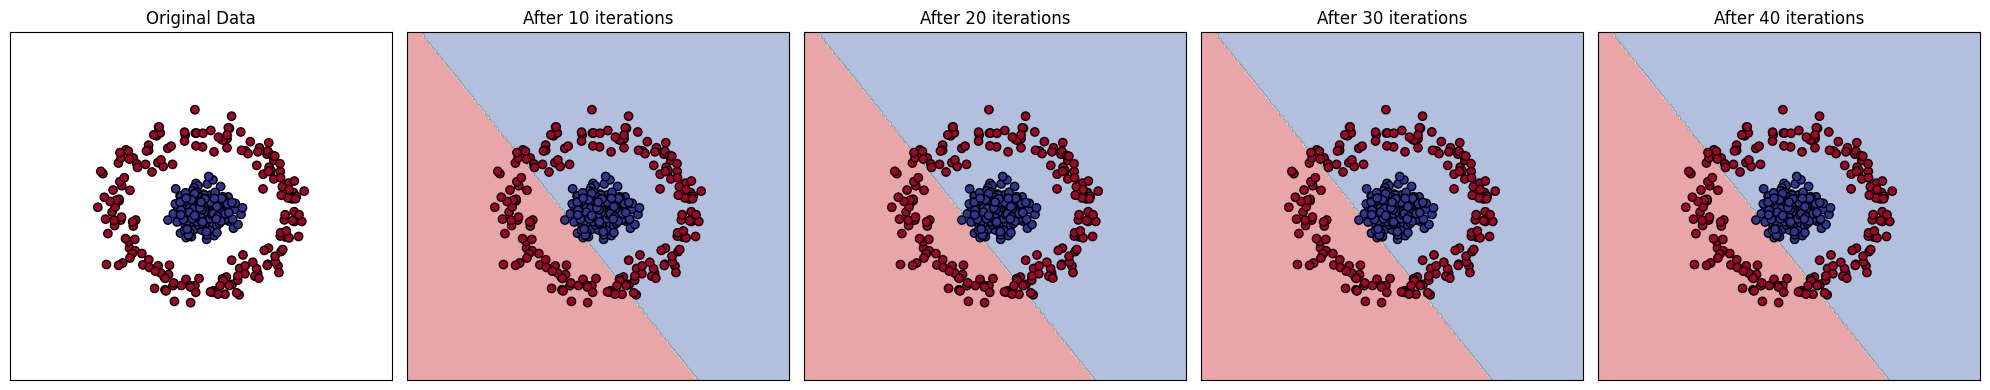

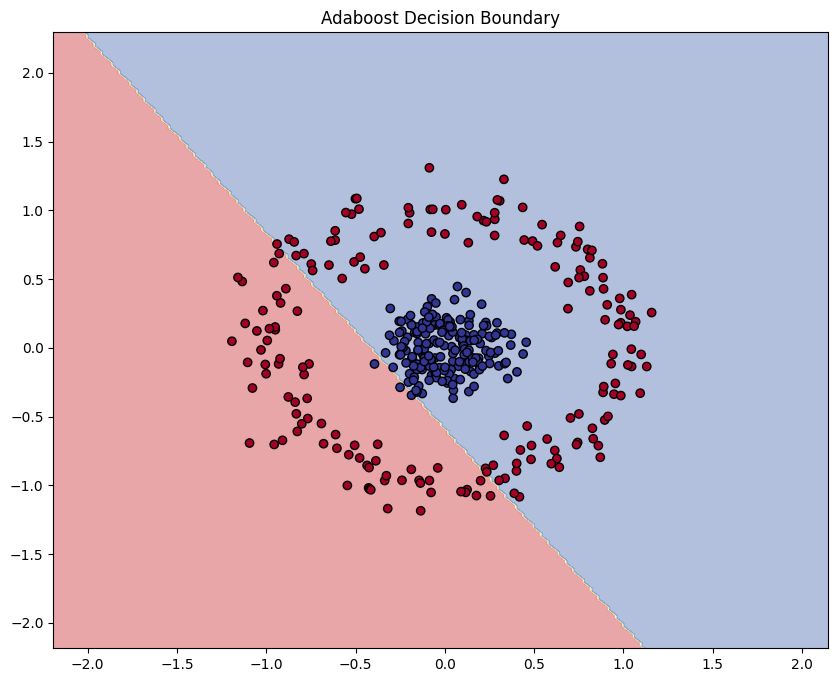

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_response.py", line 199, in _get_response_values
    classes = estimator.classe

Best parameters: {'eta': 0.1, 'n_estimators': 10}
Best cross-validation score: nan
Best model - Train accuracy: 0.3227
Best model - Test accuracy: 0.2640


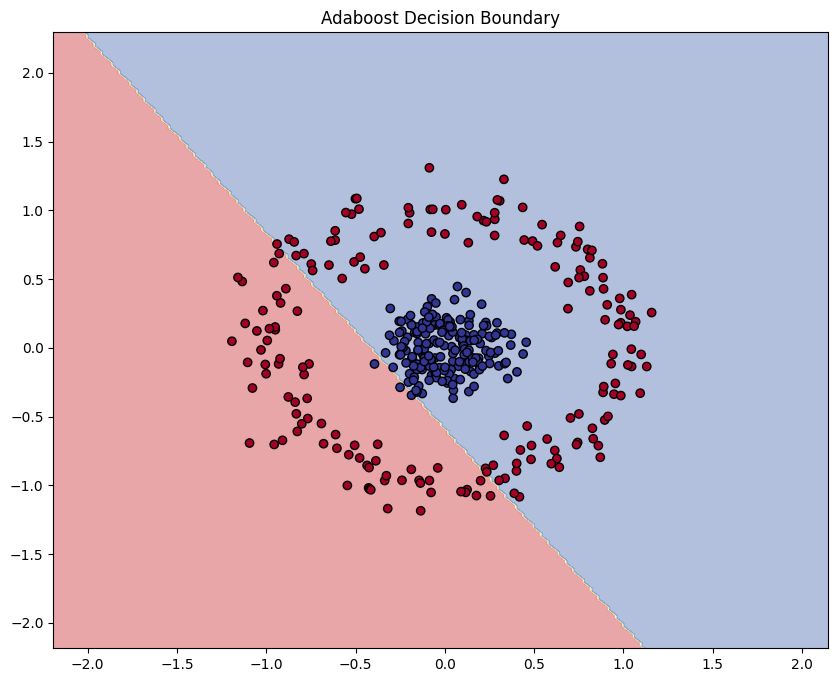


Running Adaboost with LDA:
Train accuracy: 0.3227
Test accuracy: 0.2640


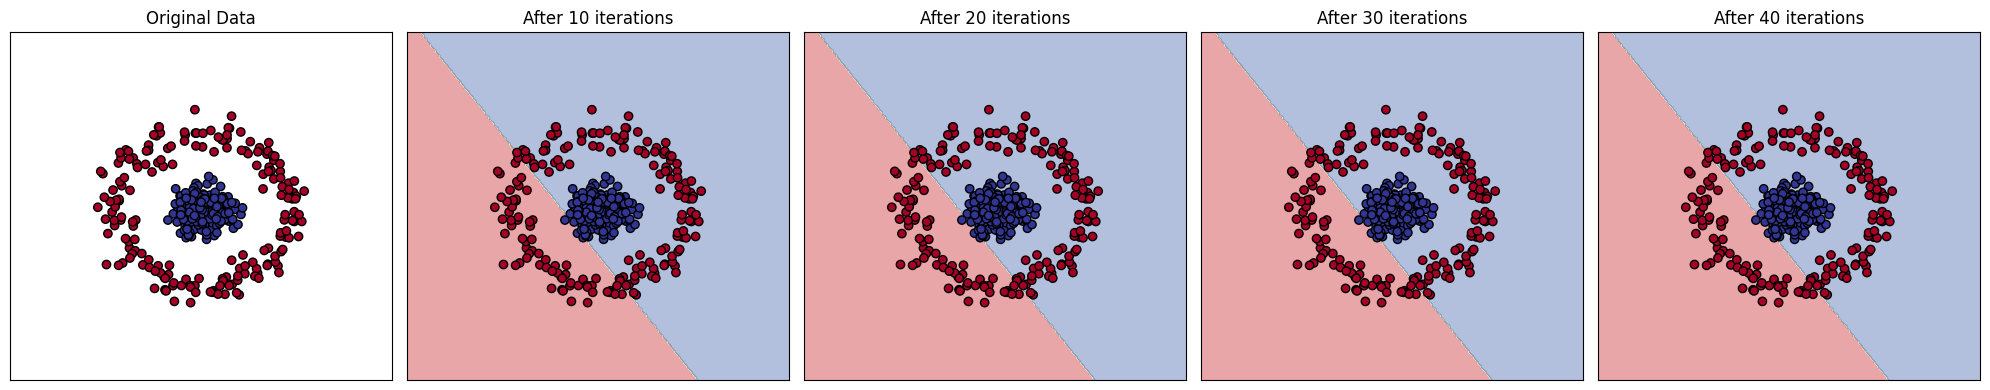

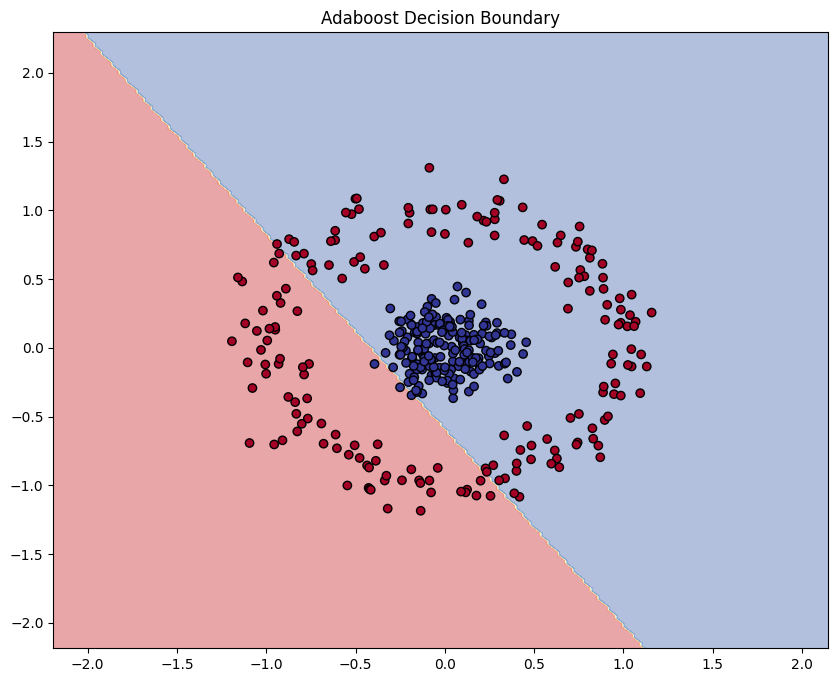

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_response.py", line 199, in _get_response_values
    classes = estimator.classe

Best parameters: {'eta': 0.1, 'n_estimators': 10}
Best cross-validation score: nan
Best model - Train accuracy: 0.3227
Best model - Test accuracy: 0.2640


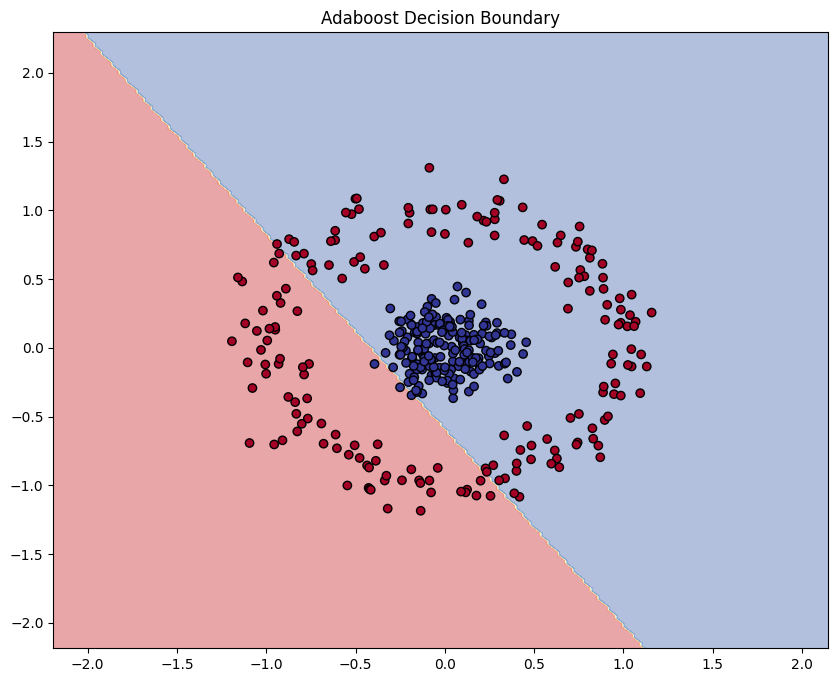

In [ ]:
# Main execution
if __name__=="__main__":
    # Generate the circle dataset
    X_train, X_test, y_train, y_test = generate_circle_data()

    # Define weak classifiers to test
    weak_classifiers = [
        ("Logistic Regression", LogisticRegression()),
        ("Decision Stump", DecisionTreeClassifier(max_depth=1)),
        ("Decision Tree(depth=3)", DecisionTreeClassifier(max_depth=3)),
        ("Linear SVM", LinearSVC()),
        ("LDA", LinearDiscriminantAnalysis())
    ]

    # Run Adaboost with each weak classifier
    for name, clf in weak_classifiers:
        print(f"\nRunning Adaboost with {name}:")
        adaboost, train_score, test_score = run_adaboost_with_weak_classifier(X_train, X_test, y_train, y_test, clf)

        # Hyperparameter tuning
        param_grid = {
            'n_estimators': [10, 50, 100],
            'eta': [0.1, 0.5, 1.0]
        }
        best_adaboost, best_params, best_score = tune_hyperparameters(X_train, y_train, adaboost, param_grid)
        print(f"Best parameters: {best_params}")
        print(f"Best cross-validation score: {best_score:.4f}")

        # Evaluate best model
        best_train_score = best_adaboost.score(X_train, y_train)
        best_test_score = best_adaboost.score(X_test, y_test)
        print(f"Best model - Train accuracy: {best_train_score:.4f}")
        print(f"Best model - Test accuracy: {best_test_score:.4f}")

        best_adaboost.visualize_final_boundary(X_train, y_train)